In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
import pystan

reload(misc)
reload(plotting)

first_year = 1992
last_year = 2012

data_dir = '.'
data_file = os.path.join(data_dir, 'tobacco_with_metadata_2017.03.15.csv')
data = misc.read_article_data(data_file, first_year, last_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'smoking_tone_annotations.csv'), first_year, last_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

framing_annotations = misc.read_article_data(os.path.join(data_dir, 'smoking_framing_annotations.csv'), first_year, last_year)
#framing_annotations = misc.compute_entropy(framing_annotations)
print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max()
print "Last date = ", last_date
last_year = last_date.year + 1


Loaded data for 22595 articles
Loaded tone annotations for 3703 articles
Loaded framing annotations for 3307 articles
Last date =  2012-12-28 00:00:00


In [2]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
#framing_annotations = misc.convert_dates(framing_annotations, first_year)

Grouped data into 86 periods


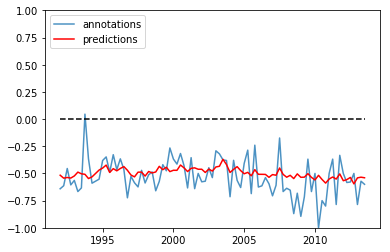

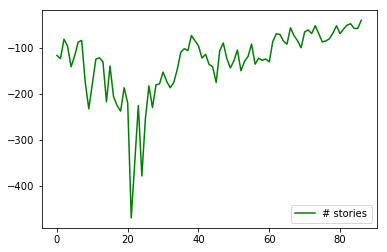

In [3]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'
#group_by = 'year'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
#grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

grouped = misc.compute_entropy(grouped)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

grouped['tone_a'] = grouped_tone_annotations['tone']
#grouped['entropy_a'] = grouped_framing_annotations['entropy']

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone / grouped_tone_annotations.stories, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone / grouped.stories, 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
ax.legend(loc='upper left')
ax.set_ylim(-1, 1)

fig, ax = plt.subplots()
ax.plot(grouped.tone, c='green', label='# stories')
ax.legend(loc='lower right')

#fig, ax = plt.subplots()
#ax.plot(grouped.stories * grouped.tone, c='green', label='# stories')
#ax.legend()

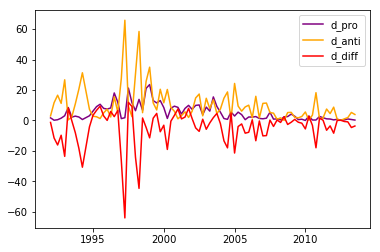

In [4]:
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']
    
grouped = misc.compute_dominance(grouped)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d_pro, c='purple', label='d_pro')
ax.plot(grouped.f_date, grouped.d_anti, c='orange', label='d_anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
ax.plot(grouped.f_date, grouped.d_pro - grouped.d_anti, c='red', label='d_diff')
ax.legend()

#fig, ax = plt.subplots()
#ax.plot(grouped.f_date, grouped.tone * grouped.stories, c='green', label='toneXstories')
#ax.legend()

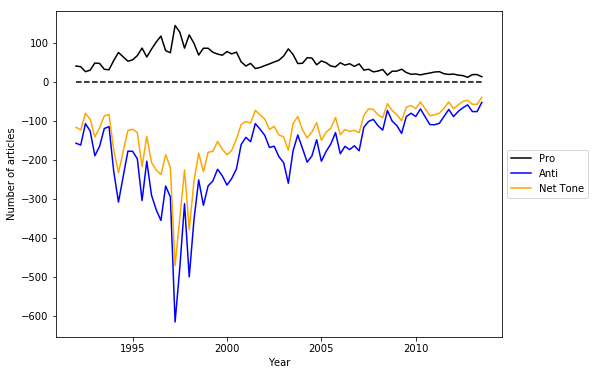

In [5]:

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(grouped.f_date, grouped.Pro, c='black', label='Pro')
ax.plot(grouped.f_date, -grouped.Anti, c='blue', label='Anti')
ax.plot(grouped.f_date, grouped.tone, c='orange', label='Net Tone')
ax.plot(grouped.f_date, np.zeros_like(grouped.f_date), 'k--', label=None)
#ax.set_ylim(-50, 50)
ax.set_ylabel('Number of articles')
ax.set_xlabel('Year')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/Users/dcard/Desktop/immigration_tone_with_net.pdf', bbox_inches='tight')

set(['#d95f02', '#66a61e', '#7570b3', '#1b9e77', '#e7298a'])


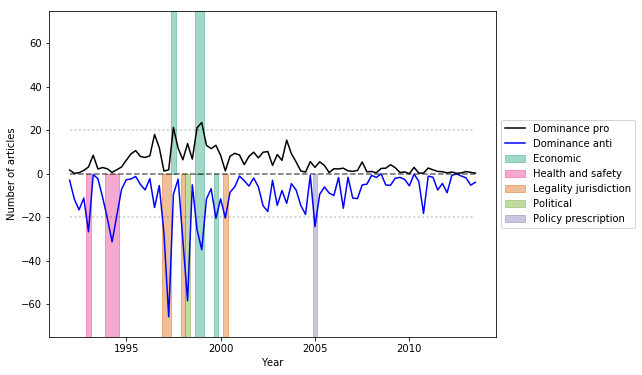

In [12]:
import re
reload(misc)
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']

CB6 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']


threshold = 20
grouped = misc.compute_dominance(grouped, threshold=threshold)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(grouped.f_date, grouped.d_pro, c='black', label='Dominance pro')
ax.plot(grouped.f_date, -grouped.d_anti, c='blue', label='Dominance anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
#grouped['d_diff2'] = grouped['d_pro2'] - grouped['d_anti2']
#ax.plot(grouped.f_date, grouped.d_pro - grouped.d_anti, c='red', label='d_diff')

pos_spans = []
anti_spans = []
pos_cur = -1
anti_cur = -1
top_set = set()
delta = grouped.iloc[1].f_date - grouped.iloc[0].f_date

for i, index in enumerate(grouped.index):
    row = grouped.loc[index]
    if row.top_pro != pos_cur:
        if i > 0 and pos_cur >= 0:
            pos_spans[-1] += [row.f_date - delta/2.0, pos_cur]
        if i < len(grouped.index) and row.top_pro >= 0:
            pos_spans.append([row.f_date - delta/2.0])
        pos_cur = row.top_pro
    if i == len(grouped.index) - 1 and pos_cur >= 0:
        pos_spans[-1] += [row.f_date + delta/2.0, pos_cur]
    top_set.add(int(row.top_pro))

    if row.top_anti != anti_cur:
        if i > 0 and anti_cur >= 0:
            anti_spans[-1] += [row.f_date - delta/2.0, anti_cur]
        if i < len(grouped.index) and row.top_anti >= 0:
            anti_spans.append([row.f_date - delta/2.0])
        anti_cur = row.top_anti
    if i == len(grouped.index) - 1 and anti_cur >= 0: 
        anti_spans[-1] += [row.f_date + delta/2.0, anti_cur]
    top_set.add(int(row.top_anti))


# UNCOMMENT THIS LINE TO REFRESH COLOURS
colors = dict(zip(list(top_set), CB6))


colors_used = set()
for span in pos_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

for span in anti_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

print colors_used

ylim = 75

ax.plot(grouped.f_date, np.zeros_like(grouped.f_date), 'k--', alpha=0.6, label=None)
ax.plot(grouped.f_date, np.ones_like(grouped.f_date)*threshold, 'k:', alpha=0.2)
ax.plot(grouped.f_date, -np.ones_like(grouped.f_date)*threshold, 'k:', alpha=0.2)
ax.set_ylim(-ylim, ylim)
ax.set_ylabel('Number of articles')
ax.set_xlabel('Year')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/Users/dcard/Desktop/smoking_dominance_' + str(threshold) + '.pdf', bbox_inches='tight')